In [1]:
import sys
import math
from collections import defaultdict, OrderedDict, Counter
import pprint as pp
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('task_cpu_90d_2.csv', names=['jeditaskid', 'processingtype', 'transformation', 'atlrel', 'site',
                                                               'cputype', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'jevts', 'eff'])

In [3]:
grouped = df[df.processingtype == 'evgen'].groupby(['site'], as_index=False)
tot_wc = grouped['wc'].sum()
a = tot_wc.sort_values('wc', ascending=False)
bigtotal_wc = a.wc.sum()
big_sites = a[a.wc > bigtotal_wc * 0.001].site.tolist()

In [4]:
grouped = df.groupby(['processingtype', 'jeditaskid', 'site'], as_index=False, sort=False)

data = defaultdict(OrderedDict)
for (p, j, s), g in grouped:
    if s not in big_sites: continue
    if p != 'evgen': continue
    x = np.average(g.cpuevt_avg, weights=g.cpu)
    y = math.sqrt(np.average((g.cpuevt_avg - x)**2, weights=g.cpu))
    data[j][s] = (x, y)

In [5]:
# Remove from data tasks with only one site
for (k, v) in data.items():
    if len(v) == 1:
        del data[k]

In [6]:
# Replace site names with numbers
i = -1
sites = set()
smap = dict()
for (k, v) in data.items():
    for s in v.keys():
        if s not in sites:
            i += 1
            smap[s] = i
            sites.add(s)
        data[k][smap[s]]= data[k][s]
        del data[k][s]

nsites = len(smap)
print 'There are %s sites in the fit' % nsites

There are 111 sites in the fit


In [7]:
# Map tasks to integers
tasks = set(data.keys())
tmap = dict()
i = 0
for x in tasks:
    tmap[x] = i
    i += 1

In [8]:
def func(k):
    total = 0.
    for _, task in data.items():   # looping on tasks
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        kf2 = np.roll(kf, -1)
        v2 = np.roll(v, -1)
        ratio = (v2 / v - kf / kf2)**2
        ratio[np.isnan(ratio)] = 0.
        ratio[np.isinf(ratio)] = 0.
        delta = np.sum(ratio[:-1])
        total += delta
    return total

In [9]:
def func2(k):
    total = 0.
    for _, task in data.items():
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        ratio = (v / v[0] - kf[0] / kf)**2
        ratio[np.isnan(ratio)] = 0.
        ratio[np.isinf(ratio)] = 0.
        delta = np.sum(ratio)
        total += delta
    return total

In [10]:
def func3(k):
    total = 0.
    for _, task in data.items():
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        ratio = (v[0] / v - kf / kf[0])**2
        ratio[np.isnan(ratio)] = 0.
        ratio[np.isinf(ratio)] = 0.
        delta = np.sum(ratio)
        total += delta
    return total

In [11]:
def func4(k):
    total = 0.
    for _, task in data.items():   # looping on tasks
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        kf2 = np.roll(kf, -1)
        v2 = np.roll(v, -1)
        ratio = (v2 / v - kf / kf2)**2
        ratio[np.isnan(ratio)] = 0.
        ratio[np.isinf(ratio)] = 0.
        delta = np.sum(ratio)
        total += delta
    return total

In [12]:
def grad(k):
    grad = np.zeros(len(k))
    for _, task in data.items():
        ns = np.array(task.keys())
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        for i in range(len(task)):
            if i == len(task) - 1:
                x1 = 0.
            else:
                x1 = -2 * (v[i+1] / v[i] - kf[i] / kf[i+1]) / kf[i+1]
            if np.isnan(x1) or np.isinf(x1): x1 = 0.
            if i == 0:
                x2 = 0.
            else:
                x2 = 2 * (v[i] / v[i-1] - kf[i-1] / kf[i]) * kf[i-1] / kf[i]**2
            if np.isnan(x2) or np.isinf(x2): x2 = 0.
            grad[ns[i]] += (x1 + x2)
    return grad

In [13]:
def grad2(k):
    grad = np.zeros(len(k))
    for _, task in data.items():
        ns = np.array(task.keys())
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        for i in range(len(task)):
            x = 0.
            if i == 0:
                for j in range(len(task)):
                    x += -2. * (v[j] / v[0] - k[0] / k[j]) / k[j]
            else:
                x = 2. * (v[i] / v[0] - k[0] / k[i]) * k[0] / k[i]**2
            grad[ns[i]] += x
    return grad

In [14]:
def grad3(k):
    grad = np.zeros(len(k))
    for _, task in data.items():
        ns = np.array(task.keys())
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        for i in range(len(task)):
            x = 0.
            if i == 0:
                for j in range(len(task)):
                    x += 2. * (v[0] / v[j] - k[j] / k[0]) * k[j] / k[0]**2
            else:
                x = -2. * (v[0] / v[i] - k[i] / k[0]) / k[0]
            grad[ns[i]] += x
    return grad

In [15]:
def grad4(k):
    grad = np.zeros(len(k))
    for _, task in data.items():
        ns = np.array(task.keys())
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([a[0] for a in task.values()])
        for i in range(len(task)):
            if i == len(task) - 1:
                x1 = -2 * (v[0] / v[i] - kf[i] / kf[0]) / kf[0]
            else:
                x1 = -2 * (v[i+1] / v[i] - kf[i] / kf[i+1]) / kf[i+1]
            if np.isnan(x1) or np.isinf(x1): x1 = 0.
            if i == 0:
                x2 = 2 * (v[i] / v[len(task)-1] - kf[len(task)-1] / kf[i]) * kf[len(task)-1] / kf[i]**2
            else:
                x2 = 2 * (v[i] / v[i-1] - kf[i-1] / kf[i]) * kf[i-1] / kf[i]**2
            if np.isnan(x2) or np.isinf(x2): x2 = 0.
            grad[ns[i]] += (x1 + x2)
    return grad

In [16]:
k_ini = np.ones(nsites)   # Initialises CPU factors for all sites to one

print 'Initial function value: ', func(k_ini)
print 'Initial function value: ', func2(k_ini)
print 'Initial function value: ', func3(k_ini)
print 'Initial function value: ', func4(k_ini)

Initial function value:  9276.85827558
Initial function value:  3725.16792974
Initial function value:  1857.30097738
Initial function value:  9455.41243276


In [17]:
check = optimize.check_grad(func, grad, k_ini)
print check

0.00118444684462


In [18]:
check = optimize.check_grad(func2, grad2, k_ini)
print check

0.000711921785147


In [19]:
check = optimize.check_grad(func3, grad3, k_ini)
print check

0.000690682075832


In [20]:
check = optimize.check_grad(func4, grad4, k_ini)
print check

0.00185998549001


In [21]:
ref = smap['CERN-PROD']
cons = ({'type': 'eq', 'fun': lambda x: x[ref] - 1})
bounds = [(0.5, 2.)] * len(k_ini)

In [22]:
result = optimize.minimize(func, k_ini, method='SLSQP', jac=grad, constraints=cons, bounds=bounds, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7870.48940344
            Iterations: 132
            Function evaluations: 376
            Gradient evaluations: 132


In [23]:
k = result.x

In [24]:
print k

[ 1.18398493  1.2549539   1.          1.41408676  1.33472856  1.30346994
  1.25963328  1.09473472  0.95117855  1.79370681  1.13050906  1.38680984
  0.97160062  1.12310096  1.17616666  1.72407103  1.15298544  1.59846386
  1.07365293  1.20041902  1.35863888  1.81495999  1.04026366  1.38521709
  1.80518373  1.62868241  0.9894252   1.14052909  1.088555    1.3402907
  1.32774362  1.48727534  1.4026187   1.31622248  1.23073997  1.0603262
  1.89984147  0.985279    1.62401032  1.20504296  1.28277084  1.86544151
  1.27943873  1.40551823  1.18922598  1.00208626  1.42452453  2.
  1.15027826  1.08679691  1.30808256  1.14237614  1.03528222  0.87518264
  1.24907892  1.28403186  1.73079417  1.27631529  1.4617014   1.50282263
  1.58478535  1.02724934  1.52559653  1.56920989  1.16964818  0.9811864
  1.52555284  1.19887656  1.01267412  1.43936089  1.01755896  1.59620719
  0.98492448  1.37811252  0.82843915  1.09095493  0.94892871  1.44340015
  1.31933175  1.47941527  1.27612124  1.13805195  1.41413703  

In [25]:
for s in sorted(smap.keys()):
    print '%s\t%f' % (s, k[smap[s]])

AGLT2_SL6	1.254954
ARNES	0.985279
ATLAS_OPP_OSG	1.166630
Australia-ATLAS	1.269319
BEIJING	1.899841
BNL_LOCAL	1.479415
BNL_PROD	1.189226
BU_ATLAS_Tier2_SL6	1.439361
CA-MCGILL-CLUMEQ-T2	1.730794
CA-SCINET-T2	1.504120
CA-VICTORIA-WESTGRID-T2	1.724071
CERN-PROD	1.000000
CERN-PROD-preprod	1.230581
CONNECT	1.525553
CONNECT_CLOUD	0.828439
CPPM	1.205043
CSCS-LCG2	1.459852
CYFRONET-LCG2	1.177261
DCSC	1.060326
DESY-HH	0.971601
DESY-HH_Condor	1.405518
DESY-ZN	1.814960
EELA-UTFSM	1.276181
FMPhI-UNIBA	1.450647
FZK-LCG2	1.386810
GR-12-TEIKAV	1.022462
GRIF-IRFU	1.259707
GRIF-LAL_HTCondor	1.624010
GRIF-LPNHE	1.142376
GoeGrid	1.805184
HPC2N	0.951179
HU_ATLAS_Tier2	1.333950
IAAS	1.502823
IEPSAS-Kosice	1.623073
IFAE	1.456084
IFIC	1.073653
IHEP_PROD	1.040264
IL-TAU-HEP	1.461701
IN2P3-CC	1.303470
IN2P3-CC-T2	1.432006
IN2P3-CC_VVL	1.309405
IN2P3-LPSC	1.308083
INFN-COSENZA-RECAS	1.002086
INFN-FRASCATI	1.071402
INFN-GENOVA	1.130509
INFN-LECCE	1.259633
INFN-MILANO-ATLASC	1.198877
INFN-NAPOLI-ATLAS	1.017559
INF

In [26]:
result2 = optimize.minimize(func2, k_ini, method='SLSQP', jac=grad2, constraints=cons, options={'disp': True, 'maxiter': 2000})

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3239001517.61
            Iterations: 23
            Function evaluations: 223
            Gradient evaluations: 23


In [269]:
k2 = result2.x

In [27]:
result3 = optimize.minimize(func3, k_ini, method='SLSQP', jac=grad3, constraints=cons, bounds=bounds, options={'disp': True, 'maxiter': 2000})

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1118.78589787
            Iterations: 24
            Function evaluations: 186
            Gradient evaluations: 20


In [28]:
k3 = result3.x

In [29]:
result4 = optimize.minimize(func4, k_ini, method='SLSQP', jac=grad4, constraints=cons, bounds=bounds, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7954.97429989
            Iterations: 133
            Function evaluations: 379
            Gradient evaluations: 133


In [276]:
k4 = result4.x

In [30]:
ntask = len(data)
nsite = len(smap)
a_ini = np.zeros(ntask)
for j, task in data.items():
    nt = tmap[j]
    a_ini[nt] = np.mean([b[0] for b in task.values()])
x_ini = np.hstack((a_ini, np.ones(nsite)))

In [31]:
def func_val(x):
    a = x[:ntask]
    k = x[ntask:]
    total = 0.
    for j, task in data.items():   # looping on tasks
        nt = tmap[j]
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([b[0] for b in task.values()])
        f_term = 1. / a[nt]**2 * (v * kf - a[nt])**2
        delta = np.sum(f_term)
        total += delta
    return total


In [32]:
def grad_val(x):
    a = x[:ntask]
    k = x[ntask:]
    g = np.zeros(len(x))
    for j, task in data.items():
        g_a = 0.
        nt = tmap[j]
        for i in task.keys():
            (v, _) = task[i]
            g_a += -2 * v * k[i] / a[nt]**2 * (v * k[i] / a[nt] - 1)
            g_k = 2 / a[nt]**2 * v * (k[i] * v - a[nt])
            g[ntask + i] += g_k
        g[nt] = g_a
    return g

In [33]:
def hess_val(x):
    a = x[:ntask]
    k = x[ntask:]
    diag = np.zeros_like(x)   # diagonal of the Hessian
    H = np.diag(diag)
    for t, task in data.items():
        h = 0.
        nt = tmap[t]
        for i in task.keys():
            (v, _) = task[i]
            h += 2 / a[nt]**4 * (3 * v**2 * k[i]**2 - 2 * v * k[i] * a[nt])
            diag[ntask + i] += 2 * v**2 / a[nt]**2
            H[nt][ntask+i] = H[ntask+i][nt] = -2 * v / a[nt]**2 * ( 2 * v * k[i] / a[nt] - 1)
        diag[nt] = h
    H = H + np.diag(diag)
    return H

In [34]:
func_val(x_ini)

1126.0210049815785

In [36]:
check = optimize.check_grad(func_val, grad_val, x_ini)
print check

0.0106721829578


In [37]:
result_val = optimize.minimize(func_val, x_ini, method='Newton-CG', jac=grad_val, hess=hess_val, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.
         Current function value: 380.395282
         Iterations: 33
         Function evaluations: 46
         Gradient evaluations: 78
         Hessian evaluations: 33


In [38]:
k_val = result_val.x[ntask:]

In [39]:
print k_val

[ 0.86520882  0.91404669  0.71357679  1.07206128  0.98716924  0.97126404
  0.91194749  0.83129141  0.73815577  1.32391912  0.84636272  0.98738493
  0.70823357  0.8093781   0.86487914  1.23952217  0.83552728  1.16045365
  0.98697063  0.87134947  1.00576569  1.33350829  0.77705858  1.02416728
  1.32696541  1.15538542  0.68923675  0.85738402  0.81867118  1.00249124
  0.98713925  1.06368707  1.09972211  0.99887528  0.96299574  0.77731405
  1.27875638  0.7447799   0.98676037  0.93701874  0.98495755  1.40446472
  0.91621857  1.03994183  0.86893323  0.75225739  1.01520642  1.60100384
  0.8759944   0.8090547   0.92040247  0.82052442  0.76165385  0.62735791
  0.92130745  0.92620045  1.29171722  0.97456414  1.04386423  1.11307666
  1.13182029  0.77090063  1.12772508  1.11104312  0.86735186  0.75128234
  1.11978783  0.87974844  0.80078893  1.00547259  0.76390912  1.17051149
  0.70662491  1.02681564  0.68039436  0.79986708  0.71422462  1.23892265
  1.00893185  1.07328368  0.89659012  0.83758994  0

In [40]:
k_sci = k * 0.713

<Container object of 3 artists>

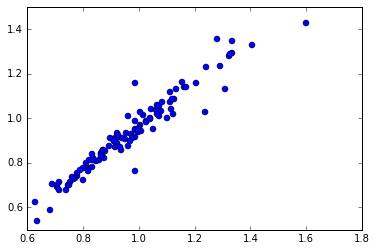

In [41]:
plt.errorbar(k_val, k_sci, fmt='o')

In [42]:
x = result_val.x
points = list()
for t, task in data.items():
    nt = tmap[t]
    for i in task.keys():
        (v, _) = task[i]
        p = v * x[ntask+i] / x[nt]
        points.append(p)

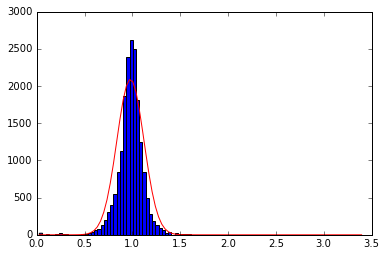

In [43]:
fig = plt.hist(points, bins=100)
n = len(points)
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / 100.
mu = np.mean(points)
sigma = np.std(points)
plt.plot(fig[1], 2 * n * binsize/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (fig[1] - mu)**2 / (2 * sigma**2)), color='r')